### Pricipal Component Analysis was done on 𝛂2 and 𝛂3 helices of both histone H2B and H4. The connecting loop-2 which links 𝛂2 and 𝛂3 helices was ignored. These helices were selected because they contact the amino acids whose residue contribution to the binding free energy was significantly affected by mutation. Coordinates was used as the collective variable for this calculation. The coordinates for all systems (Wild-Type and two mutant) was combined as one trajectory and then analyzed.

In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis import pca, align
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.ndimage.filters import gaussian_filter
import sys, math
from timeit import default_timer as timer 
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from matplotlib.font_manager import FontProperties

from matplotlib import rc
%matplotlib inline

### Universe for PCA at 0.15 M
traj_Com = "/home/augustine/Nucleosome_system/1kx5/1kx5_0.15M/combine/combine_015M.xtc"
top_Com = "/home/augustine/Nucleosome_system/1kx5/1kx5_0.15M/combine/com_WT.prmtop"
u1 = mda.Universe(top_Com, traj_Com)

### Universe for PCA at 2.4 M
traj_Com_24M = "/home/augustine/Nucleosome_system/1kx5/1kx5_2.4M/PCA_combine/combined_all_24M.xtc"
top_Com_24M = "/home/augustine/Nucleosome_system/1kx5/1kx5_2.4M/PCA_combine/com_WT_24M.prmtop"
u2 = mda.Universe(top_Com_24M, traj_Com_24M)

/home/augustine/miniconda3/envs/mdaenv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_556403/2885066837.py:8: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


#### PCA for all systems at 0.15 M

In [4]:
pc1 = pca.PCA(u1, select='name CA',
             align=True, mean=None,
             n_components=None).run()

In [5]:
backbone1 = u1.select_atoms('name CA')
transformed1 = pc1.transform(backbone1, n_components=2)
transformed1.shape

(71000, 2)

In [6]:
dt=240
df1 = pd.DataFrame(transformed1,
                  columns=['PC{}'.format(i+1) for i in range(2)])
df1['Time (ps)'] = df1.index * dt
df1.head()


,PC1,PC2,Time (ps)
0,2.905402,-2.062570,0
1,4.171429,-3.405714,240
2,3.376306,-0.332346,480
3,1.598538,-2.372728,720
4,2.732564,-1.949372,960


In [7]:
df_list1 = np.array(df1)
a1 = pd.DataFrame(df_list1)
a1.to_csv("helix_combine_015M.csv")


In [8]:
A1=pd.read_csv('helix_combine_015M.csv',names=['frame','pc1','pc2','ps'],header=0)

A1

,frame,pc1,pc2,ps
0,0,2.905402,-2.062570,0.0
1,1,4.171429,-3.405714,240.0
2,2,3.376306,-0.332346,480.0
3,3,1.598538,-2.372728,720.0
4,4,2.732564,-1.949372,960.0
...,...,...,...,...
70995,70995,-58.821041,-63.517165,17038800.0
70996,70996,-59.837036,-63.302398,17039040.0
70997,70997,-58.929635,-64.854382,17039280.0
70998,70998,-59.691288,-63.213572,17039520.0


In [9]:
### Defining a function to project the PCs on a free-energy landscape
def cal_2d(x,y,temp,R,pmf_max):
    H, xedges, yedges = np.histogram2d(x,y,density=True,bins=(75,75),range=([-85,40],[-150,75]))
    stepx = xedges[1]-xedges[0]
    stepy = yedges[1]-yedges[0]
    xx, yy = np.mgrid[xedges.min():xedges.max():stepx,yedges.min():yedges.max():stepy]
    pos = np.dstack((xx, yy))
    pmax = 0
    for i in H:
        p = i.sum()
        if p >=pmax:
            pmax = p
    print("Found pmax = ",pmax)
    # print(" xedges, yedges, H = ",(H, xedges, yedges))

    for i in range(len(H)):
        for j in range(len(H.T)):
            if H[i,j]!=0:
                H[i,j]=-R*temp*np.log(H[i,j]/pmax)
            else:
                H[i,j]=pmf_max
    # print(pos,H)
    return pos,H

pos,H=cal_2d(A1['pc1'],A1['pc2'],310,0.001987,6.0)
pos,H

smoothing_factor = 0.6
H = gaussian_filter(H,smoothing_factor)

Found pmax =  0.009169014084507016


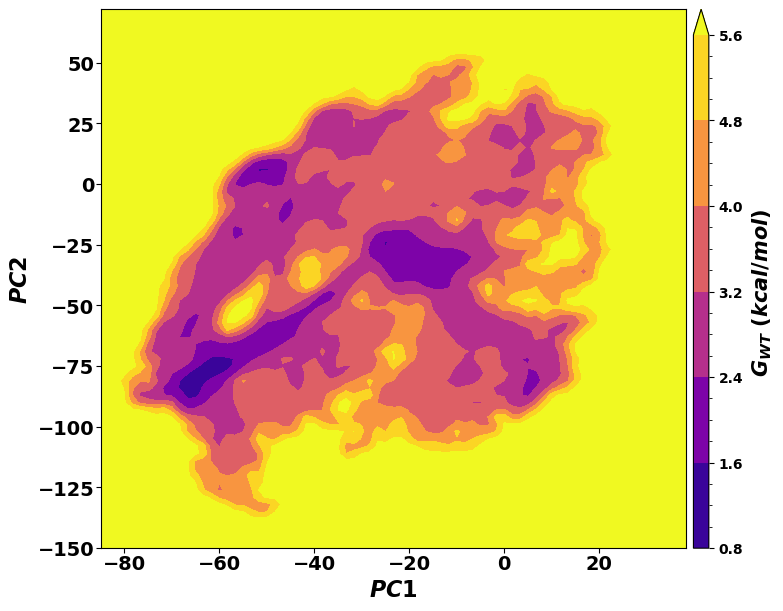

In [11]:
# Free energy landscape for all system at 0.15 M
plt.subplots(figsize=(9, 7))
plot = plt.contourf(pos[:,:,0],pos[:,:,1],H,extend='max',cmap='plasma')
font1 = {'family': 'serif', 'size': 16, 'color': 'black'}

plt.xlabel("$\it{PC1}$", fontdict=font1, weight='bold',fontsize=16)
plt.ylabel("$\it{PC2}$", fontdict=font1, weight='bold',fontsize=16)
plt.tick_params(labelsize=14, pad=1)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

cbar = plt.colorbar(plot, pad = 0.01, aspect = 35)
cbar.set_label('$G_{WT}$ ($kcal/mol$)',rotation=90,labelpad=5, fontsize = 15)
cbar.minorticks_on()

plt.show()

In [2]:
#### Defining a function to extract conformations with the lowest minima (energy)
def find_peak(data,c1,c2,min_c1,max_c1,min_c2,max_c2):

    bool_c1_max = data[c1] <= max_c1
    bool_c1_min = data[c1] >= min_c1

    bool_c2_max = data[c2] <= max_c2
    bool_c2_min = data[c2] >= min_c2

    frame = data.loc[bool_c1_min & bool_c1_max & bool_c2_min & bool_c2_max]['F']

    #print(frame)
    frames = frame.values
    
    #print(frames)
    nf = +len(frames)


    return frames

In [26]:
#Combine 1st minima (down Left right)
df = pd.read_csv("helix_combine_015M.csv")
print("Be careful with negative values for min/max!")
#peak = str(input("Peak name: "))
c1 = "PC1"
min_c1 = -63
max_c1 = -54.85

c2 = "PC2"
min_c2 = -80
max_c2 = -71

frames = find_peak(df,c1,c2,min_c1,max_c1,min_c2,max_c2)
i=1
while len(frames)>40:
    delta_x=1
    frames = find_peak(df,c1,c2,min_c1+delta_x*i,max_c1-delta_x*i,min_c2+delta_x*i,max_c2-delta_x*i)
    print(len(frames))
    i=i+1
    
for i in range(len(frames)):
    print(frames[i])
nf = +len(frames)
print("There are %s to write." % nf)
print("Using MDAnalysis version", mda.__version__)

Be careful with negative values for min/max!
2738
1500
516
12
25051
28135
29753
38024
39333
39491
39530
39603
39709
40128
52460
66666
There are 12 to write.
Using MDAnalysis version 2.5.0


In [27]:
#Combine 1st minima (down Left left)
df = pd.read_csv("helix_combine_015M.csv")
print("Be careful with negative values for min/max!")
#peak = str(input("Peak name: "))
c1 = "PC1"
min_c1 = -66.7
max_c1 = -64.6

c2 = "PC2"
min_c2 = -84
max_c2 = -80

frames = find_peak(df,c1,c2,min_c1,max_c1,min_c2,max_c2)
i=1
while len(frames)>80:
    delta_x=1
    frames = find_peak(df,c1,c2,min_c1+delta_x*i,max_c1-delta_x*i,min_c2+delta_x*i,max_c2-delta_x*i)
    print(len(frames))
    i=i+1
    
for i in range(len(frames)):
    print(frames[i])
nf = +len(frames)
print("There are %s to write." % nf)
print("Using MDAnalysis version", mda.__version__)

Be careful with negative values for min/max!
11
27579
28438
48619
49790
51137
52755
52765
52897
65792
67658
69305
There are 11 to write.
Using MDAnalysis version 2.5.0


In [28]:
#Combine 1st minima (Middle dot)
df = pd.read_csv("helix_combine_015M.csv")
print("Be careful with negative values for min/max!")
#peak = str(input("Peak name: "))
c1 = "PC1"
min_c1 = -28.5
max_c1 = -22

c2 = "PC2"
min_c2 = -26.8
max_c2 = -20.6

frames = find_peak(df,c1,c2,min_c1,max_c1,min_c2,max_c2)
i=1
while len(frames)>100:
    delta_x=1
    frames = find_peak(df,c1,c2,min_c1+delta_x*i,max_c1-delta_x*i,min_c2+delta_x*i,max_c2-delta_x*i)
    print(len(frames))
    i=i+1
    
for i in range(len(frames)):
    print(frames[i])
nf = +len(frames)
print("There are %s to write." % nf)
print("Using MDAnalysis version", mda.__version__)

Be careful with negative values for min/max!
1104
437
8
11076
11228
11248
11360
11740
12737
13166
13345
There are 8 to write.
Using MDAnalysis version 2.5.0


In [29]:
#Combine 1st minima (Middle right half)
df = pd.read_csv("helix_combine_015M.csv")
print("Be careful with negative values for min/max!")
#peak = str(input("Peak name: "))
c1 = "PC1"
min_c1 = -20.5
max_c1 = -10

c2 = "PC2"
min_c2 = -38.5
max_c2 = -28

frames = find_peak(df,c1,c2,min_c1,max_c1,min_c2,max_c2)
i=1
while len(frames)>80:
    delta_x=1
    frames = find_peak(df,c1,c2,min_c1+delta_x*i,max_c1-delta_x*i,min_c2+delta_x*i,max_c2-delta_x*i)
    print(len(frames))
    i=i+1
    
for i in range(len(frames)):
    print(frames[i])
nf = +len(frames)
print("There are %s to write." % nf)
print("Using MDAnalysis version", mda.__version__)

Be careful with negative values for min/max!
2443
1546
813
251
8
9637
10092
10093
16717
16912
16973
19441
20384
There are 8 to write.
Using MDAnalysis version 2.5.0


In [30]:
#Combine 1st minima (Middle left half below dot)
df = pd.read_csv("helix_combine_015M.csv")
print("Be careful with negative values for min/max!")
#peak = str(input("Peak name: "))
c1 = "PC1"
min_c1 = -32
max_c1 = -21

c2 = "PC2"
min_c2 = -39
max_c2 = -30

frames = find_peak(df,c1,c2,min_c1,max_c1,min_c2,max_c2)
i=1
while len(frames)>20:
    delta_x=1
    frames = find_peak(df,c1,c2,min_c1+delta_x*i,max_c1-delta_x*i,min_c2+delta_x*i,max_c2-delta_x*i)
    print(len(frames))
    i=i+1
    
for i in range(len(frames)):
    print(frames[i])
nf = +len(frames)
print("There are %s to write." % nf)
print("Using MDAnalysis version", mda.__version__)

Be careful with negative values for min/max!
763
335
96
9
12306
12307
12309
14050
32635
33378
34820
34821
34823
There are 9 to write.
Using MDAnalysis version 2.5.0


In [48]:
#Combine 1st minima (left up, the dot)
df = pd.read_csv("helix_combine_015M.csv")
print("Be careful with negative values for min/max!")
#peak = str(input("Peak name: "))
c1 = "PC1"
min_c1 = -51.3
max_c1 = -48.5

c2 = "PC2"
min_c2 = 5.8
max_c2 = 8

frames = find_peak(df,c1,c2,min_c1,max_c1,min_c2,max_c2)
i=1
while len(frames)>100:
    delta_x=1
    frames = find_peak(df,c1,c2,min_c1+delta_x*i,max_c1-delta_x*i,min_c2+delta_x*i,max_c2-delta_x*i)
    print(len(frames))
    i=i+1
    
for i in range(len(frames)):
    print(frames[i])
nf = +len(frames)
print("There are %s to write." % nf)
print("Using MDAnalysis version", mda.__version__)

Be careful with negative values for min/max!
13
42552
42915
43004
43061
43086
43121
43227
43235
43241
44821
44834
45290
55416
There are 13 to write.
Using MDAnalysis version 2.5.0


In [51]:
#Combine 1st minima (left up, below dot)
df = pd.read_csv("helix_combine_015M.csv")
print("Be careful with negative values for min/max!")
#peak = str(input("Peak name: "))
c1 = "PC1"
min_c1 = -55
max_c1 = -50

c2 = "PC2"
min_c2 = 0.5
max_c2 = 5

frames = find_peak(df,c1,c2,min_c1,max_c1,min_c2,max_c2)
i=1
while len(frames)>100:
    delta_x=1
    frames = find_peak(df,c1,c2,min_c1+delta_x*i,max_c1-delta_x*i,min_c2+delta_x*i,max_c2-delta_x*i)
    print(len(frames))
    i=i+1
    
for i in range(len(frames)):
    print(frames[i])
nf = +len(frames)
print("There are %s to write." % nf)
print("Using MDAnalysis version", mda.__version__)

Be careful with negative values for min/max!
174
12
43777
43779
45491
45498
45507
45518
45550
45707
45728
45804
45891
55374
There are 12 to write.
Using MDAnalysis version 2.5.0


In [70]:
#Combine 1st minima (Right down)
df = pd.read_csv("helix_combine_015M.csv")
print("Be careful with negative values for min/max!")
#peak = str(input("Peak name: "))
c1 = "PC1"
min_c1 = 4.5
max_c1 = 8.6

c2 = "PC2"
min_c2 = -88
max_c2 = -79

frames = find_peak(df,c1,c2,min_c1,max_c1,min_c2,max_c2)
i=1
while len(frames)>100:
    delta_x=1
    frames = find_peak(df,c1,c2,min_c1+delta_x*i,max_c1-delta_x*i,min_c2+delta_x*i,max_c2-delta_x*i)
    print(len(frames))
    i=i+1
    
for i in range(len(frames)):
    print(frames[i])
nf = +len(frames)
print("There are %s to write." % nf)
print("Using MDAnalysis version", mda.__version__)

Be careful with negative values for min/max!
253
8
5946
7118
7206
7376
7452
7462
8013
8804
There are 8 to write.
Using MDAnalysis version 2.5.0


In [104]:
# Calculating the mean and standard deviation of the distance and the dihedral angle between H2B-𝛂2 and H4-𝛂3 helices. 
import statistics

#Wild-Type Dihedral angles
sample = [-26.43, -27.29, -25.80, -21.57, -22.17, -28.09, -21.11, -25.19, -21.42, -28.29, -24.93, -26.14, -24.12, -25.29, -23.05, -21.45, -26.09, -25.06, -23.48, -28.19, -21.89, -29.52, -26.68, -25.63]
print(statistics.mean(sample))
print("Standard Deviation of sample is % s "
                % (statistics.stdev(sample)))

#Wild-Type Distance 
sample = [8.06, 8.49, 8.84, 8.52, 8.86, 8.78, 8.30, 8.51, 8.80, 8.42, 8.09, 8.28, 8.74, 8.44, 9.17, 8.48, 8.45, 8.52, 8.46, 8.76, 8.62]
print(statistics.mean(sample))
print("Standard Deviation of sample is % s "
                % (statistics.stdev(sample)))

#-------------------------------------------------------------------------------------------------------------------------

# H2BE76 Dihedral angles
sample = [-22.26, -26.10, -20.15, -20.98, -24.67, -21.55, -24.41, -28.22, -23.86, -28.26, -12.83, -25.05, -17.54, -18.49, -25.95, -24.91, -26.99, -25.80, -27.38, -29.79, -27.22, -29.34, -20.97, -25.95, -28.48, -26.21, -26.20, -28.00, -21.03, -24.02, -26.48]
print(statistics.mean(sample))
print("Standard Deviation of sample is % s "
                % (statistics.stdev(sample)))

# H2BE76 Distance
sample = [10.03, 10.49, 10.54, 9.63, 9.66, 9.79, 9.95, 9.94, 9.96, 10.76, 10.11, 9.85, 10.78, 10.65, 10.47, 10.38, 10.90, 10.68, 9.69, 10.16, 10.93, 10.73, 9.63, 10.18, 10.25, 10.23]
print(statistics.mean(sample))
print("Standard Deviation of sample is % s "
                % (statistics.stdev(sample)))


#-------------------------------------------------------------------------------------------------------------------------

# H4R92T Dihedral angles
import statistics
sample = [-22.75, -23.50, -17.66, -19.37, -20.25, -22.95, -22.80, -20.50, -21.982]
print(statistics.mean(sample))
print("Standard Deviation of sample is % s "
                % (statistics.stdev(sample)))

# H4R92T Distance
import statistics
sample = [9.71, 9.44, 9.44, 9.22, 9.25, 8.86, 9.20, 9.45, 9.11, 10.09]
print(statistics.mean(sample))
print("Standard Deviation of sample is % s "
                % (statistics.stdev(sample)))

-24.953333333333333
Standard Deviation of sample is 2.4810177902147976 
8.551904761904762
Standard Deviation of sample is 0.26562415265971284 
-24.48677419354839
Standard Deviation of sample is 3.8252933544124206 
10.245
Standard Deviation of sample is 0.417672120209142 
-21.30688888888889
Standard Deviation of sample is 1.9715697073933527 
9.376999999999999
Standard Deviation of sample is 0.3404588407167926 


### PCA for all systems at 2.4 M

In [2]:
pc1 = pca.PCA(u2, select='name CA',
             align=True, mean=None,
             n_components=None).run()

In [3]:
backbone1 = u2.select_atoms('name CA')
transformed1 = pc1.transform(backbone1, n_components=2)
transformed1.shape

(75000, 2)

In [4]:
dt=240
df1 = pd.DataFrame(transformed1,
                  columns=['PC{}'.format(i+1) for i in range(2)])
df1['Time (ps)'] = df1.index * dt
df1.head()

,PC1,PC2,Time (ps)
0,-2.613764,-0.617583,0
1,-1.848329,-0.832882,240
2,-1.689999,-1.563177,480
3,-0.284879,0.237979,720
4,-1.071890,-0.335711,960


In [5]:
df_list1 = np.array(df1)
a1 = pd.DataFrame(df_list1)
a1.to_csv("helix_combine_24M.csv")
A1=pd.read_csv('helix_combine_24M.csv',names=['frame','pc1','pc2','ps'],header=0)

A1

,frame,pc1,pc2,ps
0,0,-2.613764,-0.617583,0.0
1,1,-1.848329,-0.832882,240.0
2,2,-1.689999,-1.563177,480.0
3,3,-0.284879,0.237979,720.0
4,4,-1.071890,-0.335711,960.0
...,...,...,...,...
74995,74995,-50.503165,-24.834190,17998800.0
74996,74996,-50.155730,-24.124025,17999040.0
74997,74997,-50.271638,-26.273029,17999280.0
74998,74998,-50.275371,-26.126052,17999520.0


In [16]:
### Defining a function to project the PCs on a free-energy landscape
def cal_2d(x,y,temp,R,pmf_max):
    H, xedges, yedges = np.histogram2d(x,y,density=True,bins=(75,75),range=([-150,56.25],[-93.75,18.75]))
    stepx = xedges[1]-xedges[0]
    stepy = yedges[1]-yedges[0]
    xx, yy = np.mgrid[xedges.min():xedges.max():stepx,yedges.min():yedges.max():stepy]
    pos = np.dstack((xx, yy))
    pmax = 0
    for i in H:
        p = i.sum()
        if p >=pmax:
            pmax = p
    print("Found pmax = ",pmax)
    # print(" xedges, yedges, H = ",(H, xedges, yedges))

    for i in range(len(H)):
        for j in range(len(H.T)):
            if H[i,j]!=0:
                H[i,j]=-R*temp*np.log(H[i,j]/pmax)
            else:
                H[i,j]=pmf_max
    # print(pos,H)
    return pos,H

pos,H=cal_2d(A1['pc1'],A1['pc2'],310,0.001987,6.0)
pos,H

smoothing_factor = 0.6
H = gaussian_filter(H,smoothing_factor)

Found pmax =  0.016213333333333333


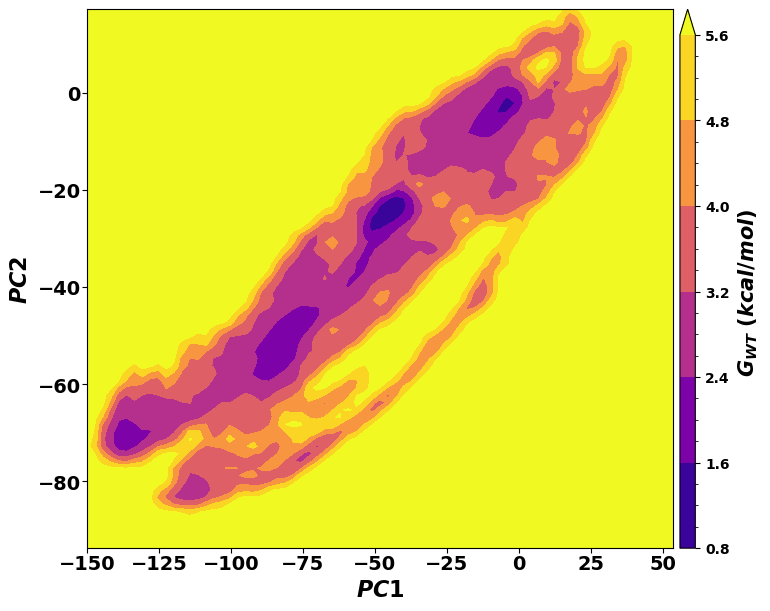

In [18]:
# Free energy landscape for all system at 2.4 M
plt.subplots(figsize=(9, 7))
#plt.style.use('seaborn-poster')
plot = plt.contourf(pos[:,:,0],pos[:,:,1],H,extend='max',cmap='plasma')
font1 = {'family': 'serif', 'size': 16, 'color': 'black'}

plt.xlabel("$\it{PC1}$", fontdict=font1, weight='bold',fontsize=16)
plt.ylabel("$\it{PC2}$", fontdict=font1, weight='bold',fontsize=16)
plt.tick_params(labelsize=14, pad=1)
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

cbar = plt.colorbar(plot, pad = 0.01, aspect = 35)
cbar.set_label('$G_{WT}$ ($kcal/mol$)',rotation=90,labelpad=5, fontsize = 15)
cbar.minorticks_on()

plt.show()

In [2]:
def find_peak(data,c1,c2,min_c1,max_c1,min_c2,max_c2):

    bool_c1_max = data[c1] <= max_c1
    bool_c1_min = data[c1] >= min_c1

    bool_c2_max = data[c2] <= max_c2
    bool_c2_min = data[c2] >= min_c2

    frame = data.loc[bool_c1_min & bool_c1_max & bool_c2_min & bool_c2_max]['F']

    #print(frame)
    frames = frame.values
    #print(frames)
    nf = +len(frames)


    return frames

In [3]:
# 1st minima(top right)
df = pd.read_csv("helix_combine_24M.csv")
print("Be careful with negative values for min/max!")
#peak = str(input("Peak name: "))
c1 = "PC1"
min_c1 = -6
max_c1 = 0

c2 = "PC2"
min_c2 = 1
max_c2 = 3.2

frames = find_peak(df,c1,c2,min_c1,max_c1,min_c2,max_c2)
i=1
while len(frames)>50:
    delta_x=1
    frames = find_peak(df,c1,c2,min_c1+delta_x*i,max_c1-delta_x    #}
*i,min_c2+delta_x*i,max_c2-delta_x*i)
    print(len(frames))
    i=i+1
    
for i in range(len(frames)):
    print(frames[i])
nf = +len(frames)
print("There are %s to write." % nf)
print("Using MDAnalysis version", mda.__version__)

Be careful with negative values for min/max!
12
2792
2921
26635
26924
26930
26951
27012
27015
28428
28489
38612
50185
There are 12 to write.
Using MDAnalysis version 2.5.0


In [4]:
# 1st minima(middle right)
df = pd.read_csv("helix_combine_24M.csv")
print("Be careful with negative values for min/max!")
#peak = str(input("Peak name: "))
c1 = "PC1"
min_c1 = -52.5
max_c1 = -40

c2 = "PC2"
min_c2 = -27
max_c2 = -22.995

frames = find_peak(df,c1,c2,min_c1,max_c1,min_c2,max_c2)
i=1
while len(frames)>500:
    delta_x=1
    frames = find_peak(df,c1,c2,min_c1+delta_x*i,max_c1-delta_x    #}
*i,min_c2+delta_x*i,max_c2-delta_x*i)
    print(len(frames))
    i=i+1
    
for i in range(len(frames)):
    print(frames[i])
nf = +len(frames)
print("There are %s to write." % nf)
print("Using MDAnalysis version", mda.__version__)

Be careful with negative values for min/max!
3615
10
51626
60516
61131
64588
66996
67052
67191
67248
71128
74067
There are 10 to write.
Using MDAnalysis version 2.5.0


In [27]:
# 1st minima(middle left down)
df = pd.read_csv("helix_combine_24M.csv")
print("Be careful with negative values for min/max!")
#peak = str(input("Peak name: "))
c1 = "PC1"
min_c1 = -80
max_c1 = -72

c2 = "PC2"
min_c2 = -52
max_c2 = -45.8

frames = find_peak(df,c1,c2,min_c1,max_c1,min_c2,max_c2)
i=1
while len(frames)>100:
    delta_x=1
    frames = find_peak(df,c1,c2,min_c1+delta_x*i,max_c1-delta_x    #}
*i,min_c2+delta_x*i,max_c2-delta_x*i)
    print(len(frames))
    i=i+1
    
for i in range(len(frames)):
    print(frames[i])
nf = +len(frames)
print("There are %s to write." % nf)
print("Using MDAnalysis version", mda.__version__)

Be careful with negative values for min/max!
1193
427
14
30118
30625
30871
32632
34475
48534
48539
48739
48919
56112
56136
56209
56254
58562
There are 14 to write.
Using MDAnalysis version 2.5.0


In [40]:
# 1st minima(middle left up)
df = pd.read_csv("helix_combine_24M.csv")
print("Be careful with negative values for min/max!")
#peak = str(input("Peak name: "))
c1 = "PC1"
min_c1 = -86.5
max_c1 = -80

c2 = "PC2"
min_c2 = -58.4
max_c2 = -52

frames = find_peak(df,c1,c2,min_c1,max_c1,min_c2,max_c2)
i=1
while len(frames)>50:
    delta_x=1
    frames = find_peak(df,c1,c2,min_c1+delta_x*i,max_c1-delta_x    #}
*i,min_c2+delta_x*i,max_c2-delta_x*i)
    print(len(frames))
    i=i+1
    
for i in range(len(frames)):
    print(frames[i])
nf = +len(frames)
print("There are %s to write." % nf)
print("Using MDAnalysis version", mda.__version__)

Be careful with negative values for min/max!
1036
318
14
8854
9418
18676
18678
18719
18720
18725
18750
30237
48251
53316
53318
53661
56087
There are 14 to write.
Using MDAnalysis version 2.5.0


In [69]:
# 1st minima(left down left)
df = pd.read_csv("helix_combine_24M.csv")
print("Be careful with negative values for min/max!")
#peak = str(input("Peak name: "))
c1 = "PC1"
min_c1 = -140
max_c1 = -131

c2 = "PC2"
min_c2 = -72.1
max_c2 = -68.085

frames = find_peak(df,c1,c2,min_c1,max_c1,min_c2,max_c2)
i=1
while len(frames)>50:
    delta_x=1
    frames = find_peak(df,c1,c2,min_c1+delta_x*i,max_c1-delta_x    #}
*i,min_c2+delta_x*i,max_c2-delta_x*i)
    print(len(frames))
    i=i+1
    
for i in range(len(frames)):
    print(frames[i])
nf = +len(frames)
print("There are %s to write." % nf)
print("Using MDAnalysis version", mda.__version__)

Be careful with negative values for min/max!
985
11
12300
13240
13370
14769
14799
15422
15728
16442
16654
17448
17621
There are 11 to write.
Using MDAnalysis version 2.5.0


In [74]:
# 1st minima(left down left)
df = pd.read_csv("helix_combine_24M.csv")
print("Be careful with negative values for min/max!")
#peak = str(input("Peak name: "))
c1 = "PC1"
min_c1 = -119
max_c1 = -110

c2 = "PC2"
min_c2 = -86
max_c2 = -77.5

frames = find_peak(df,c1,c2,min_c1,max_c1,min_c2,max_c2)
i=1
while len(frames)>50:
    delta_x=1
    frames = find_peak(df,c1,c2,min_c1+delta_x*i,max_c1-delta_x    #}
*i,min_c2+delta_x*i,max_c2-delta_x*i)
    print(len(frames))
    i=i+1
    
for i in range(len(frames)):
    print(frames[i])
nf = +len(frames)
print("There are %s to write." % nf)
print("Using MDAnalysis version", mda.__version__)

Be careful with negative values for min/max!
459
281
112
8
23502
23575
23688
23709
23738
23790
23915
23967
There are 8 to write.
Using MDAnalysis version 2.5.0


In [19]:
# Wild-Type Dihedral angles
#WT_24M (Down Left/Right)
import statistics
sample = [-27.74, -19.20, -23.00, -21.56, -24.39, -23.02, -25.10, -19.29, -26.71, -21.24, -26.14, -19.06, -19.15, -20.96, -23.62, -19.54, -21.04, -23.56, -17.34]
print(statistics.mean(sample))
print("Standard Deviation of sample is % s "
                % (statistics.stdev(sample)))

# Wild-Type Distance
sample = [8.27, 8.44, 9.38, 8.76, 8.59, 9.55, 9.22, 8.71, 9.00, 8.39, 8.88, 8.74, 9.45, 9.03, 8.86, 9.10, 9.02, 8.39, 8.65]
print(statistics.mean(sample))
print("Standard Deviation of sample is % s "
                % (statistics.stdev(sample)))

#-------------------------------------------------------------------------------------------------------------------------

# H2BE76K Dihedral angles
#2nd minima (Top right (E76K) )
sample = [-24.30, -26.45, -25.12, -25.44, -24.07, -24.42, -28.75, -26.35, -22.78, -21.50, -25.32] #-18.70, -19.92, -18.66, 
print(statistics.mean(sample))
print("Standard Deviation of sample is % s "
                % (statistics.stdev(sample)))

# H2BE76K Distance
sample = [9.41, 9.58, 10.42, 10.24, 9.52, 9.60, 9.08, 9.62, 10.23, 9.22, 9.89, 9.75] # 8.72, 8.99,
print(statistics.mean(sample))
print("Standard Deviation of sample is % s "
                % (statistics.stdev(sample)))


#-------------------------------------------------------------------------------------------------------------------------

# H4R92T Dihedral angles
#3nd minima (Middle Right (R92T)
sample = [-25.01,  -22.12, -22.25, -17.85, -20.11, -18.07, -18.31, -20.18, -19.75, -10.97, -7.67, -13.01,] #-29.32,-26.15,
print(statistics.mean(sample))
print("Standard Deviation of sample is % s "
                % (statistics.stdev(sample)))

# H4R92T Distance
sample = [9.93, 8.55, 8.71, 9.13, 9.03, 9.00, 8.73, 9.38,  ] #, 7.57, 7.47, 8.07,  8.19, 8.20, 7.87,
print(statistics.mean(sample))
print("Standard Deviation of sample is % s "
                % (statistics.stdev(sample)))

-22.192631578947367
Standard Deviation of sample is 2.948432431169077 
8.864736842105263
Standard Deviation of sample is 0.37163854035657096 
-24.954545454545457
Standard Deviation of sample is 1.9273005143794448 
9.713333333333333
Standard Deviation of sample is 0.41445107910306733 
-17.941666666666666
Standard Deviation of sample is 5.023187747985849 
9.057500000000001
Standard Deviation of sample is 0.4408028389848943 
